# Another 1D GP Example

We generate realizations of a simple one dimensional Gaussian Process with zero mean and Matérn covariance. Then we use the LaplaceInterpolation procedure to produce the interpolation.

## Generate some data with Matèrn covariance 

We generate multivariate normal data having zero mean and Matern covariance. 

In [1]:
using GaussianProcesses, LaplaceInterpolation, Random, LinearAlgebra
using Plots, Statistics, StatsPlots, BenchmarkTools
Random.seed!(20140430);

fn = "matern.jl"
# fn        = dirname(dirname(pathof(LaplaceInterpolation)))*"/matern.jl"
include(fn)

dbobjective (generic function with 1 method)

In [2]:
function sqdist(r, interp, discard)
    return sum(abs2, r[discard] .- interp[discard])
end

sqdist (generic function with 1 method)

## A single realization on a toy example

In [3]:
# Training data
n = 10
n2 = 20
v = Float64.(vcat(1,n2,randperm(n2-2)))
x = sort(v[1:n])
y = sin.(2π * x * 0.1) + 0.05*randn(n)

keep = Int64.(x)
discard = sort(Int64.(v[(n+1):n2]))

# The Matern parameters are set on a log scale
ν = 2.5
ll = 0.5
lσ = 0.0 #0.05

nrealiz = 1

# Aspect ratio
h = 1.0

# Dimension, Matern parameter, etc
d = 1
# m = nu + d/2
m = 2
# epsilon = sqrt(2*nu)/length_scale
epsilon = sqrt(3)/exp(ll)

# Generate a single realization of Matern data
realiz, sigsq = Matern_sim([exp(lσ), ν, 1/exp(ll), 0.0], n2)

([0.00938515281412533, -0.08023174334908456, -0.671016198047595, -0.33770948012728863, -0.8865284857500382, 0.007763456033595812, -0.6811720586806339, -0.8488421731077125, -0.46342404764856593, 0.5842927548412032, 0.24224773386184673, -0.752845173360964, -0.637299079007451, -0.30537855388595925, -0.2399625372050228, 0.11172727917079806, -0.3498410452442127, 0.00618890315232159, -0.5999070050231946, -0.6944283865880684], 0.1625041306508395)

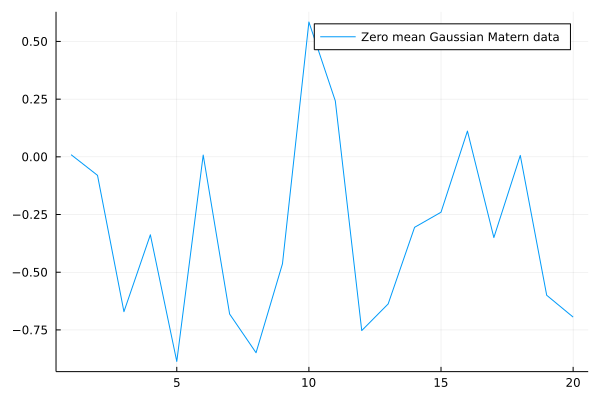

In [4]:
plot(realiz, label = "Zero mean Gaussian Matern data")

## Interpolate using Matérn and Laplace interpolation

Here we assume the Matérn parameters are known and interpolate using them. We need to convert between the log-parameters given to the GP function above and the notation we've used, m, and $\epsilon$. 

In [5]:
y_lap = mapslices(z -> matern_1d_grid(z, discard, 1, 1.0, h), realiz, dims = 1)
y_mat = mapslices(z -> matern_1d_grid(z, discard, m, epsilon, h), realiz, dims = 1)

20-element Array{Float64,1}:
 -0.08618737727030505
 -0.14533318192633207
 -0.28919820659667544
 -0.5533362564746029
 -0.8865284857500382
 -0.7160044552210545
 -0.6811720586806339
 -0.8488421731077125
 -0.38135707277488085
  0.06345950569323776
  0.24224773386184673
 -0.752845173360964
 -0.6163384258676821
 -0.4018182343120515
 -0.2399625372050228
  0.11172727917079806
 -0.3498410452442127
 -0.45670452879126133
 -0.5999070050231946
 -0.6944283865880684

┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::GPE{Adjoint{Float64,Array{Float64,1}},Array{Float64,1},MeanZero,Mat52Iso{Float64},GaussianProcesses.FullCovariance,GaussianProcesses.IsotropicData{Array{Float64,2}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.Scalar{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/charlottehaley/.julia/packages/Plots/HcxwM/src/pipeline.jl:26


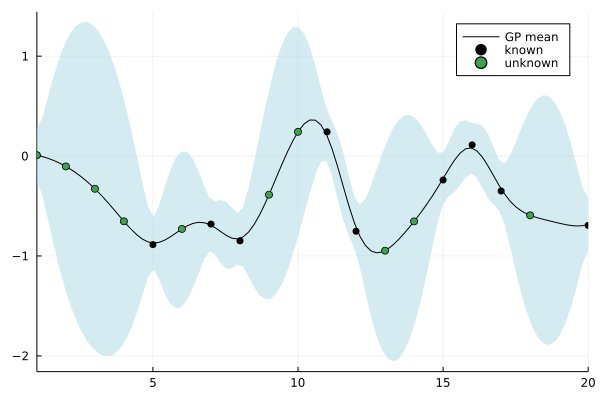

In [6]:
mZero = MeanZero()                   #Zero mean function
kern = Matern(ν, ll, lσ)                  #Sqaured exponential kernel (note that hyperparameters are on the log scale)

gp = GP(Float64.(keep),realiz[keep],mZero,kern) 
μ, σ² = predict_y(gp,Float64.(discard))
plot(gp, label = ["GP mean" "known"])
scatter!(discard, μ, label = "unknown")

Plotting the realization atop the interpolation.

Squared distance between Laplace interpolation and the truth: 1.1903303491813588
Squared distance between Matern interpolation and the truth: 1.2315047325072208


┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::GPE{Adjoint{Float64,Array{Float64,1}},Array{Float64,1},MeanZero,Mat52Iso{Float64},GaussianProcesses.FullCovariance,GaussianProcesses.IsotropicData{Array{Float64,2}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.Scalar{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/charlottehaley/.julia/packages/Plots/HcxwM/src/pipeline.jl:26


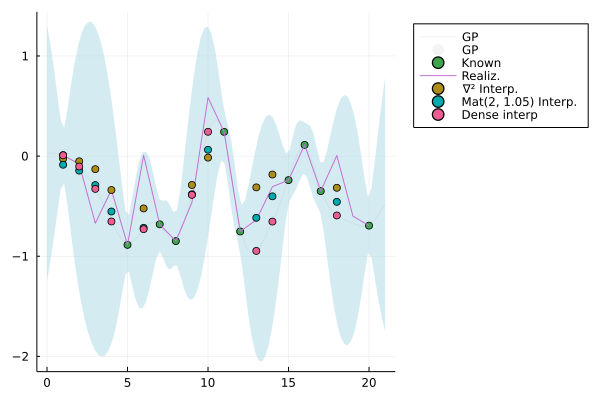

In [7]:
println("Squared distance between Laplace interpolation and the truth: $(sqdist(realiz, y_lap, discard))")
println("Squared distance between Matern interpolation and the truth: $(sqdist(realiz, y_mat, discard))")

plot(gp, label = "GP", alpha = 0.05, legend = :outertopright, xlims = [0, maximum(x) + 1])
scatter!(keep, realiz[keep], label="Known")
plot!(realiz, label = "Realiz.")
scatter!(discard, y_lap[discard], label = "∇² Interp.")
scatter!(discard, y_mat[discard], label = "Mat($m, $(round(epsilon, sigdigits = 3))) Interp.")
scatter!(discard, μ, label = "Dense interp")

# png("../paper/figures/Onedim_toy_eg")

# Statistical Averages

Clearly, we cannot say anything about the general behavior of such an approximation with just one realization.

## Generate more data

Need to generate more data and vary both size of the data and roughness. We will benchmark the code. 

In [8]:
# Training data
n = 100
n2 = 1000
v = Float64.(randperm(n2))
x = sort(unique(vcat(1,n2,v[1:n-2])))

keep = Int64.(x)
discard = sort(Int64.(v[(n+1):n2]))

# The Matern parameters are set on a log scale
ν = 1.5
#ll = 0.5
#lσ = 0.0 #0.05
nrealiz = 1000
m = 2

realiz = zeros(n2, nrealiz)
sigsq = zeros(nrealiz)

function fillmat!(realiz, sigsq, lσ, ν, ll, n2, nrealiz)
    for i = 1:nrealiz
        realiz[:,i], sigsq[i] = Matern_sim([exp(lσ), ν, 1/exp(ll), 0.0], n2)
    end
end

fillmat!(realiz, sigsq, lσ, ν, ll, n2, nrealiz)

## Benchmark the interpolation

### Laplace interpolation

In [9]:
lt = @benchmark matern_1d_grid(realiz[:,1], discard, 1, 1.0, h)

BenchmarkTools.Trial: 5844 samples with 1 evaluation.
 Range (min … max):  628.144 μs …   6.601 ms  ┊ GC (min … max): 0.00% … 63.98%
 Time  (median):     761.604 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   848.166 μs ± 618.550 μs  ┊ GC (mean ± σ):  7.96% ±  9.13%

  █                                                              
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁
  1.04 ms          Histogram: frequency by time          803 μs <

 Memory estimate: 1.56 MiB, allocs estimate: 145.

### Matérn interpolation

In [10]:
mt = @benchmark matern_1d_grid(realiz[:,2], discard, m, epsilon, h)

BenchmarkTools.Trial: 4823 samples with 1 evaluation.
 Range (min … max):  777.734 μs …   5.126 ms  ┊ GC (min … max): 0.00% … 58.74%
 Time  (median):     942.266 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.029 ms ± 557.663 μs  ┊ GC (mean ± σ):  6.24% ±  8.96%

  █                                                              
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁▁▁▁ ▁▁▁ ▁
  1.41 ms          Histogram: frequency by time          905 μs <

 Memory estimate: 1.93 MiB, allocs estimate: 146.

### Dense (GP) Interpolation

In [11]:
gp = GP(Float64.(keep),realiz[keep,3],mZero,kern)

gpt = predict_y(gp, Float64.(discard))

([0.013573341361099209, 0.019567656032484424, 0.03790053764030211, 0.08805410512887804, 0.19591933906909526, 0.36529270917217377, 0.36507907795284483, 0.19526916250639786, 0.08638814974585025, 0.034129263798039024  …  -0.009391753972018208, -0.026913468687592906, -0.07308359069994397, -0.183764312152486, -0.41046517428080964, -0.7477216499689961, -0.4539271231222527, 0.22645779587042492, 0.5016614970367551, 0.19754624464541753], [0.036301822395361574, 0.44326238416407676, 0.8493762084871239, 0.9545249150200926, 0.8493762084871239, 0.4432623841640769, 0.4436167315884671, 0.8538905953288572, 0.9861327807849221, 1.01329245945679  …  1.0182320039151749, 1.0176254897196146, 1.0131911507686764, 0.9855560898342355, 0.8515458314315674, 0.43911980643292897, 0.3636877113993779, 0.35283019329949245, 0.19681430599241773, 0.03623740531632276])

In [12]:
size(realiz[keep,3]), discard

((100,), [1, 2, 3, 4, 5, 6, 8, 9, 10, 11  …  989, 990, 991, 992, 993, 994, 996, 997, 999, 1000])

In [13]:
gpt = @benchmark predict_y(gp, Float64.(discard))

DomainError: [91mDomainError with -26.0:[39m
[91mlog will only return a complex result if called with a complex argument. Try log(Complex(x)).[39m

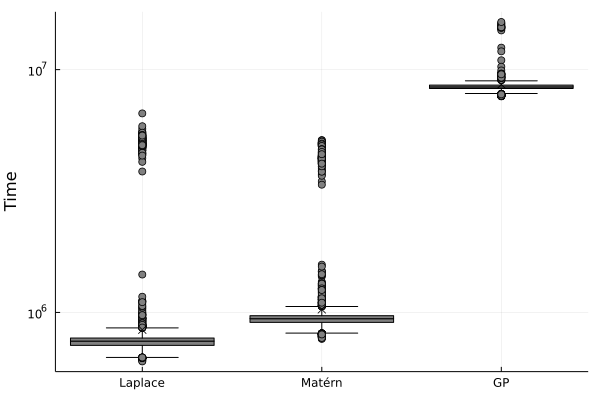

In [14]:
mlt = mean(lt).time
mmt = mean(mt).time
mgpt = mean(gpt).time

pt = boxplot([lt.times, mt.times, gpt.times], label = ["Laplace" "Matern" "GP"], ylabel = "Time",
        xtick = ([1.0, 2.0, 3.0], ["Laplace", "Matérn", "GP"]), legend = false, c = :gray, yscale = :log10)
scatter!(pt, 1:3, [mlt, mmt, mgpt], markershape = :x , c = :black, label = "Mean")
# png(pt, "../paper/figures/Onedim_time_boxplot")

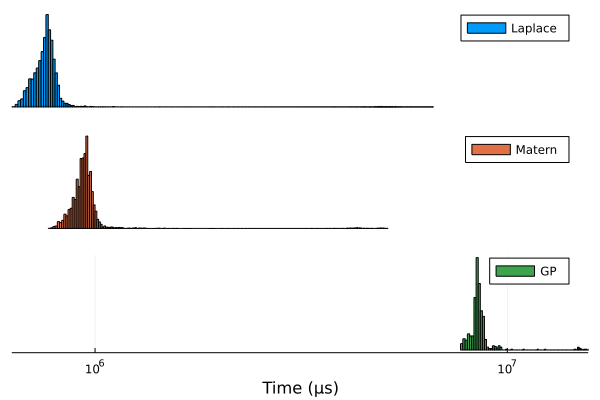

In [15]:
minlt = minimum(lt).time
maxgp = maximum(gpt).time

ptime = plot(histogram(lt.times, xticks = [], xaxis = false, label = "Laplace", c = 1), 
     histogram(mt.times, xticks = [], xaxis = false, label = "Matern", c = 2), 
     histogram(gpt.times, label ="GP", c = 3), layout = (3,1), 
     xscale = :log10, xlims=(minlt, maxgp), legend = true, yaxis = false, yticks = [],
     # ylabel = ["Laplace" "Matern" "GP"], 
     xlabel = ["" "" "Time (μs)"])
#png(ptime, "../paper/figures/Onedim_time_hist")

## Accuracy of the approximation

In [16]:
y_lap = mapslices(z -> matern_1d_grid(z, discard, 1, 1.0, h), realiz, dims = 1)
y_mat = mapslices(z -> matern_1d_grid(z, discard, m, epsilon, h), realiz, dims = 1);
μ = mapslices(z -> predict_y(GP(x, z[keep, 1], MeanZero(), Matern(ν, ll, lσ)), Float64.(discard))[1], realiz, dims = 1)

900×1000 Array{Float64,2}:
 -0.00167077   -0.00786051    0.0136097   …  -0.00585464    0.00786802
 -0.0219255     0.0030629     0.0208005      -0.00675729    0.0336844
 -0.0658283     0.0243836     0.0398873      -0.0102683     0.0911856
 -0.157297      0.0645045     0.0860404      -0.0204195     0.213801
 -0.339045      0.141648      0.181576       -0.0422904     0.459128
 -0.642178      0.269274      0.342461    …  -0.0794534     0.86898
 -0.642461      0.269627      0.342263       -0.0793336     0.869208
 -0.339826      0.142624      0.181029       -0.041959      0.459759
 -0.159119      0.066783      0.084762       -0.0196458     0.215275
 -0.0697341     0.0292682     0.0371466      -0.00860956    0.0943444
 -0.0293148     0.0123038     0.0156155   …  -0.00361921    0.0396604
 -0.0119754     0.0050263     0.00637907     -0.00147847    0.0162017
 -0.00479088    0.00201082    0.00255199     -0.000591469   0.00648163
  ⋮                                       ⋱                
  0.0009

Looking at one of the realizations and the interpolation we get, we see that the squared distance between the interpolation and the truth is smaller for the Matérn.

Mean squared distance between the Laplacian interpolation and the truth: 727.6698857601866.
Mean squared distance between the Matern interpolation and the truth: 748.743156859227.
Mean squared distance between the GP interpolation and the truth: 756.8062362036914.


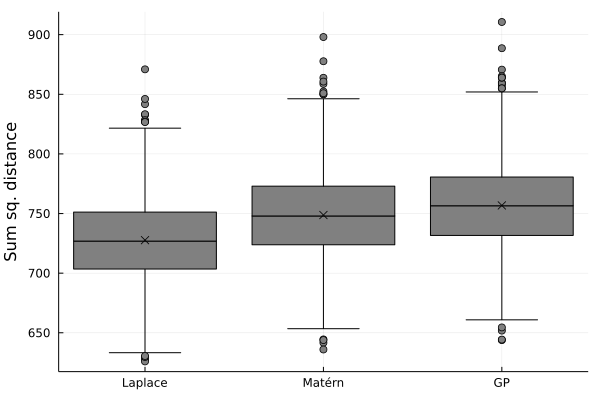

In [17]:
# Compute the squared distance for all the interpolations
lap_dist = map(i -> sqdist(realiz[:, i], y_lap[:, i], discard), 1:nrealiz)
mat_dist = map(i -> sqdist(realiz[:, i], y_mat[:, i], discard), 1:nrealiz)
gp_dist = map(i -> sqdist(realiz[discard, i], μ[:, i], 1:(n2-n)), 1:nrealiz)

ml = mean(lap_dist)
mm = mean(mat_dist)
mgp = mean(gp_dist)

println("Mean squared distance between the Laplacian interpolation and the truth: $(mean(lap_dist)).")
println("Mean squared distance between the Matern interpolation and the truth: $(mean(mat_dist)).")
println("Mean squared distance between the GP interpolation and the truth: $(mean(gp_dist)).")

p1 = boxplot([lap_dist, mat_dist, gp_dist], label = ["Laplace" "Matern" "GP"], ylabel = "Sum sq. distance",
        xtick = ([1.0, 2.0, 3.0], ["Laplace", "Matérn", "GP"]), legend = false, c = :gray)
scatter!(p1, 1:3, [ml, mm, mgp], markershape = :x , c = :black, label = "Mean")

# png(p1, "../paper/figures/Onedim_dist_boxplot")

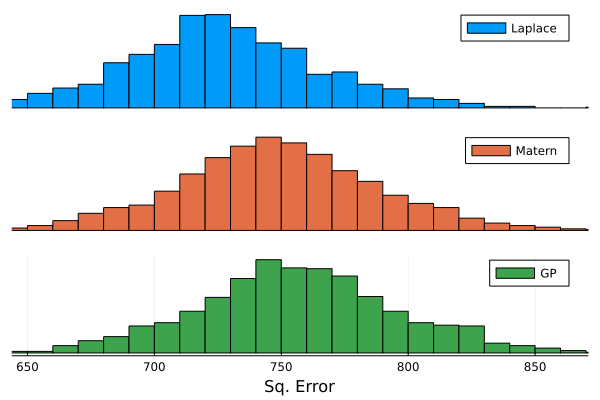

In [18]:
minltd = minimum(gp_dist)
maxgpd = maximum(lap_dist)

pacc = plot(histogram(lap_dist, xticks = [], xaxis = false, label = "Laplace", c = 1), 
     histogram(mat_dist, xticks = [], xaxis = false, label = "Matern", c = 2), 
    histogram(gp_dist, label ="GP", c = 3), 
    yaxis = false, yticks = [], xlabel = ["" "" "Sq. Error"], xlims=(minltd, maxgpd),
    layout = (3,1))
# png(pacc, "../paper/figures/Onedim_dist_hist")